# Closing the loop with a Proportional-Derivative controller

We have seen in the previous notebook how to do a simple control loop that read sensors and applied torque commands. However, we did not use the sensor measurements to compute the torque commands.

<img src="images/control_loop.png" width=600>

Now we would like to do our first closed-loop controller. We will design a simple Proportional-Derivative (PD) position controller. The goal of the controller is to compute a command that will move the joints of the robot to a desired position.

Assume that we want the first joint, with measurement position $\theta$, to move to the desired position $\theta_{des}$. The idea is to apply a command proportional to the error between the measured and desired position (the P in PD controller). The  error is
$$\textrm{error} = (\theta_{des} - \theta)$$  and
the desired torque to apply to the join will be $\tau = P \cdot \textrm{error} = P (\theta_{des} - \theta)$ where $P$ is a constant.

However, when using only a term proportional to the position, the controller will tend to create oscillations and get easily unstable (you can try!). It is then a good idea to add a term proportional to the time derivative of the error (the D term), i.e. proportional to the velocity.
The time derivative of the error is
$$\frac{d}{dt}\textrm{error} = \frac{d}{dt}(\theta_{des} - \theta) =  \dot{\theta}_{des} - \dot{\theta}$$

So a PD controller takes the general form
$\tau = P (\theta_{des} - \theta) + D (\dot{\theta}_{des} - \dot{\theta})$
where $P$ and $D$ are positive numbers called the **PD gains**
Intuitively it applies a command that tries to follow at the same time a desired position and a desired velocity (which dampens fast oscillations).

When we want to be in a static position, $\dot{\theta}_{des}$ will be 0, but if we want to follow a trajectory $\theta_{des}(t)$ which varies over time, the derivative $\dot{\theta}_{des}(t)$ will not be 0 anymore.

# Example of a simple PD control loop

First import some libraries we need for this lab:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.set_printoptions(precision=3) #Limit the print precision to 3 digits
np.set_printoptions(suppress=True) # Disable scientifi number notation when printing numpy arrays

## Simulation

### Starting the Simulator

Before going to the real robot, let's familiarize ourselves with the robot in the class through its simulated model. We need to import the class the encapsulates the Mujoco simulator code into a simple to use robot object. Instantiate the simulated robot as follows:

**Important:** If you are running the notebook in Docker, make sure you that you have executed `xhost +` command in the terminal of your Ubuntu computer.

In [2]:
from NYUFinger.sim import NYUFingerSimulator
robot_sim = NYUFingerSimulator()

You should see the simulator window pop up like this:

<p align="center">
<img src="images/simulator.png" width=800>
</p>



### Main control loop
This is the main code that you will have to change. This code initializes a few variables and then runs a control loop (the `for` statement), i.e. reads robot sensors -> do some computation -> send torque command to the actuators -> repeat

In [ ]:
# we can now send a desired motor command and simulate the behavior of the robot
# we send 0.1Nm on the first joint
# we also record the measured state of the robot

# below is a sample code to run the simulation / collect sensor and command data

run_time = 10 # Duration of the experiment in seconds. Feel free to change it
dt = 0.01 # How frequently you run the control. Here we are running it at 100Hz (100 times per second).

P = np.array([1.8,1.8,1.8])
D = np.array([0.08, 0.08, 0.08])

## Let's make sure lists so we can record the state of our robot and plot it later
measured_positions = []
measured_velocities = []
desired_torques = []
timestamps = []

# Record the initla state of the robot:
q, dq = robot_sim.get_state()
q0 = q.copy()
dq0 = dq.copy()

# We can set the desired joint position (q_des) and desired joint velocity (dq_des) to anything.
# but here we set the desired joint position to the joint positions of the robot before we run the controller. 
# this way, the robot should stay at whatever configuration it was before you run this cell 

#q_des = np.array([0,0,0.8*np.sin(np.pi*run_time)])
#dq_des = np.zeros(3)

start_time = time.time()
while time.time()-start_time < run_time: # Keep running untill run_time seconds is passed since when we started the cell.
    time_now = time.time()
    q_des = np.array([0,0,0.8*np.sin(np.pi*time_now)])
    dq_des = np.zeros(3)
    # we read the position and velocities of the joints from the robot or simulation
    q, dq = robot_sim.get_state()
    
    # we compute the desired torques
    error = q_des - q # the position error for all the joints (it's a 3D vector)
    d_error = dq_des-dq # the velocity error for all the joints
    joint_torques = P * error + D * d_error
    # we compute the desired torques as a PD controller
    desired_torques.append(joint_torques)
    # we send them to the robot
    robot_sim.send_joint_torque(joint_torques)

    # we store these values for later use. use .copy() to make sure we sure a copy of state is stored.
    measured_positions.append(q.copy()) 
    measured_velocities.append(dq.copy())
    desired_torques.append(joint_torques.copy())
    timestamps.append(time_now-start_time)

    #Wait for the dt deadile to pass before going back and repating everything
    while time.time()-time_now < dt:
        time.sleep(0.0001)

KeyboardInterrupt: 

## Plotting data after the simulation
we stored some data (joint angles and time) while the control loop was running above
Here is an example of plots we can generate with this data.
You can of course generate any types of plot relevant to your problem.

In [7]:
measured_positions = np.vstack(measured_positions)
measured_velocities = np.vstack(measured_velocities)
desired_torques = np.vstack(desired_torques)
timestamps = np.array(timestamps)

Text(0.5, 1.0, 'joint velocities')

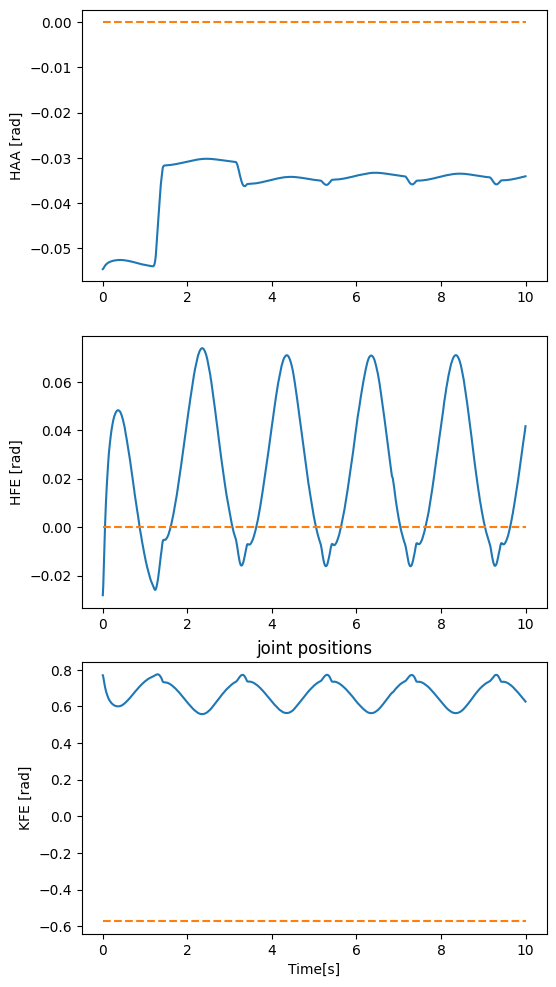

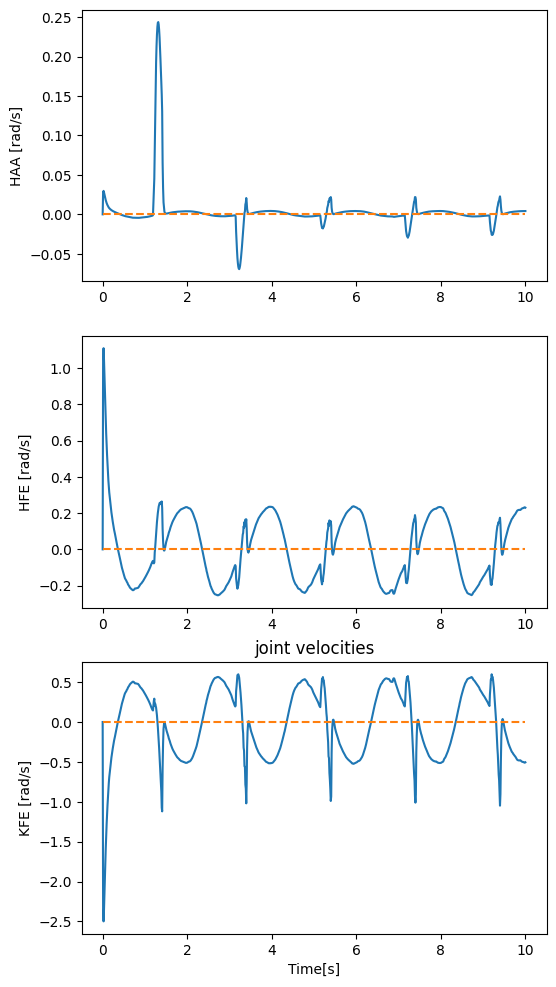

In [8]:
# we plot the measured position and velocities of all the joints
# and add the desired values
joint_names = ["HAA", "HFE", "KFE"]
plt.figure(figsize=[6, 12])
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(timestamps, measured_positions[:,i])
    plt.plot(timestamps, np.ones_like(timestamps)*q_des[i],'--')
    plt.ylabel(joint_names[i] + ' [rad]')

plt.xlabel('Time[s]')
plt.title('joint positions')

plt.figure(figsize=[6, 12])
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(timestamps, measured_velocities[:,i])
    plt.plot(timestamps, np.ones_like(timestamps)*dq_des[i],'--')
    plt.ylabel(joint_names[i] + ' [rad/s]')
plt.xlabel('Time[s]')
plt.title('joint velocities')

### Questions:
(submit a pdf with detailed answers to these questions, including the plots through Brightspace)

1. Describe qualitatively what you observe when you increase/decrease P and D.

2. Tune the P and D gains to have a good tracking of the positions $[0,0,\frac{\pi}{2}]$ without any oscillations. The P and D gains need not be the same for different joints. What gains did you find? Plot the position and velocities of each joints as a function of time with these gains. (starting from the original initial robot configuration).

3. Use the PD controller to do the following task: keep the position of the first two joints fixed and follows the following position trajectory for the last joint $0.8 \sin(\pi t)$. Plot the results (positions and velocities as a function of time for all joints). Simulate for at least 10 seconds.

4. Do question 3. on the real robot (you might need to adapt the gains of the controller).

5. (Bonus) Change the joint trajectories to get the robot to draw a circle in the air with its fingertip. Is it easy or difficult?

## Real Robot

Now that you know what to do and learned how to control the robot in simultion, let's make it real and try the same on the real robot. 

**Important:** Make sure you reset the notebook kernel before continuing so that nothing you did previously is mixed up with what you will do next. 

Make sure the robot is powered on and connected to your PC. Then run the following cell to make an object that talks with it:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.set_printoptions(precision=3) #Limit the print precision to 3 digits
np.set_printoptions(suppress=True) # Disable scientifi number notation when printing numpy arrays
from NYUFinger.real import NYUFingerHardware

robot_real = NYUFingerHardware()

If above didn't run successfully, call a TA. Otherwise, you should be able to read the sensors on the robot like this:

In [ ]:
q, dq = robot_real.get_state()
assert q is not None, 'The robot did not send its state to the PC. Ask a TA for help.'
print('Joint Position:')
print(q)
print('Joint Velocity:')
print(dq)

Our real robot has can sense how much each joint has moved since it's turned on but it has no idea what the absolute value of the joint angles are. In other words, the robot has no way of knowing how it looked before waking up! Here we need to put the robot in a known configuration and let it know. After this, the robot will be able to keep track of its joint configurations. 

First, carefully move the robot's joints so that it looks like the following picture:

![image.png](images/robot_home.png)

Now, while carefully holding the robot, run the following cell to reset the joint sensors and call a TA if you see an error. 

In [ ]:
robot_real.reset_sensors()

To make sure we did the job right, let's visualize the numbers it returns using its 3D model and compare how it think it looks to what it really looks in reality. First, make a visualizer object:

In [ ]:
from NYUFinger.utils.vis import NYUFingerVisualizer
visulizer = NYUFingerVisualizer()

Now we continiously read the real robot's state and send it to the visualizer in a loop. If everyhing is working right, you should see the robot in visualizer move and look the same way as the real robot:

In [ ]:
start_time = time.time()
while time.time()-start_time < 30:
    q, dq = robot_real.get_state()
    visulizer.show(q)
    time.sleep(0.02)

If everything looks right, you're ready to try the control loop for the real robot:

In [ ]:
# we can now send a desired motor command and simulate the behavior of the robot
# we send 0.1Nm on the first joint
# we also record the measured state of the robot

# below is a sample code to run the simulation / collect sensor and command data

run_time = 20 # Duration of the experiment in seconds. Feel free to change it
dt = 0.01 # How frequently you run the control. Here we are running it at 100Hz (100 times per second).

P = np.array([1.5, 1.5, 1.5])*10
D = np.array([0.01, 0.01, 0.01])

## Let's make sure lists so we can record the state of our robot and plot it later
measured_positions = []
measured_velocities = []
desired_torques = []
timestamps = []

# Record the initla state of the robot:
q, dq = robot_real.get_state()
q0 = q.copy()
dq0 = dq.copy()

# We can set the desired joint position (q_des) and desired joint velocity (dq_des) to anything.
# but here we set the desired joint position to the joint positions of the robot before we run the controller. 
# this way, the robot should stay at whatever configuration it was before you run this cell 

q_des = q0
dq_des = np.zeros(3)

start_time = time.time()
while time.time()-start_time < run_time: # Keep running untill run_time seconds is passed since when we started the cell.
    time_now = time.time()

    # we read the position and velocities of the joints from the robot or simulation
    q, dq = robot_real.get_state()
    
    # we compute the desired torques
    error = q_des - q # the position error for all the joints (it's a 3D vector)
    d_error = dq_des-dq # the velocity error for all the joints
    joint_torques = P * error + D * d_error
    # we compute the desired torques as a PD controller
    desired_torques.append(joint_torques)
    # we send them to the robot
    robot_real.send_joint_torque(joint_torques)

    # we store these values for later use. use .copy() to make sure we sure a copy of state is stored.
    measured_positions.append(q.copy()) 
    measured_velocities.append(dq.copy())
    desired_torques.append(joint_torques.copy())
    timestamps.append(time_now-start_time)

    #Wait for the dt deadile to pass before going back and repating everything
    while time.time()-time_now < dt:
        time.sleep(0.0001)